In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.text_cell { font-size:18pt; }</style>"))

import sys 
sys.path.append('../warpspeed')

from predict_metrics import *
import sympy as sp
from warpspeedkernel import *
import matplotlib.pyplot as plt

# Modeling the SpMV in MiniFE using WARPSPEED

## Address Expressions

Warpspeed uses address expressions to estimate data transfer volumes. 

For the 2D 4pt stencil, define the fields "src" and "dst" with
 - the referenced addresses
 - dimensions
 - datatype length
 - alignment 

In [ ]:

stencilKernel = WarpspeedKernel(loadFields = [Field(name = "src",
                                                    addresses=[("tidx + 1", "tidy", "0"),
                                                               ("tidx -1", "tidy", "0"),
                                                               ("tidx", "tidy + 1", "0"),
                                                               ("tidx", "tidy - 1", "0")],
                                                     dimensions=(800, 800, 1),
                                                     datatype=8, alignment=1)],
                                storeFields = [Field(name = "dst",
                                                     addresses = [("tidx", "tidy", "0")],
                                                     dimensions= (800, 800, 1),
                                                     datatype=8,
                                                     alignment=1)],
                                registers=32)              




**Fields** and addresses are 3D by default. (>3 hasn't come up yet, but possible).

Some analyses (L2 cache) work in the 3D domain, others (L1 cache) need linear addresses:



In [ ]:
                   
print("3D Addresses:")
for a in stencilKernel.loadFields[0].NDAddresses:
    print(a)
print()
print("Linearized Addresses:")
for a in stencilKernel.loadFields[0].linearExpressions:
    print(a)

print()

Next step is configuring a **launch configuration**
with
 - thread block size
 - total thread grid dimensions
 - device model

In [ ]:
lc = LaunchConfig.compute(stencilKernel, (256, 1, 1), (798, 798, 1), (1,1,1), DeviceAmpereA100_80GB())

Compute basic metrics (mostly volumes):

In [ ]:
basic = BasicMetrics.compute(lc, DeviceAmpere(), stencilKernel)
print(basic)

Compute derived metrics (balances, performance estimates)

In [ ]:
pred = DerivedMetrics(lc, basic, DeviceAmpere())
print(display(HTML(pred.html())))

## The Challenge:

graph by Stephan Geisler, MuCoSim 22/23

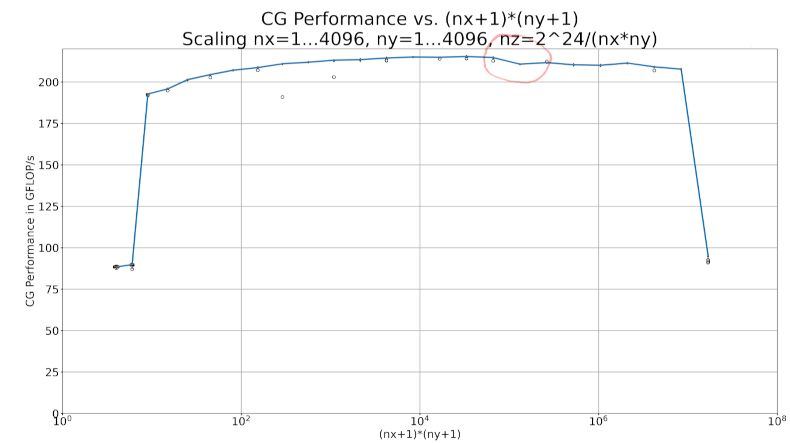

Is the small kink due to layer conditions? Can warpspeed reproduce the effect?

**Problems:**
 - no control flow: matrix formats like CRS or sell-C-σ have variable row length
 - no indirect accesses

**But:** 
 - in miniFE's pseudo unstructured mesh, all rows have same non zero count -> ellpack
 - column indices can be expressed analytically for miniFE
 
 
## Fields:
 - **vector entries:** linearized for the matrix multiplication, but the problem space is 3D -> stay in 3D space.
   
   Iteration space is also 3D. Enumerate all 27 3D addresses accessed by a single thread:


In [ ]:
xloads = []
loadFields = []
for z in {-1, 0, 1}:
    for y in {-1, 0, 1}:
        for x in {-1, 0, 1}:
            xloads.append(("tidx + " + str(x), "tidy + " + str(y), "tidz + " + str(z)))
for l in xloads:
    print(l)

loadFields.append(Field(name="X",
                        addresses = xloads,
                        datatype = 8, 
                        dimensions = (802, 802, 802),
                        alignment = 0))

 - **column indices** and **matrix entries:** linearize the 3D thread coordinates. Use datatype size 8 for matrix entries, size 4 for column indices:

In [ ]:
matrixLoads = []
for row in range(0, 27):
    matrixLoads.append(
          (
            "(tidx + tidy * {0} + tidz * {0} * {1}) + {3} * {0} * {1} * {2}".format(
                800, 800, 800, row),
            "0",
            "0",
          ))

loadFields.append(Field("mat", matrixLoads, 8, (800, 800, 800 * 27), 0))
loadFields.append(Field("idx", matrixLoads, 4, (800, 800, 800 * 27), 0))
print(loadFields[1].linearExpressions)

 - **result vector:** a single store 

In [ ]:
storeFields = [ Field(name = "Y",
                      addresses = [("tidx", "tidy", "tidz")],
                      datatype = 8,
                      dimensions = (802, 802, 802), 
                      alignment = 0) ]

## Putting it all together:

In [ ]:
preds = {}
blockSize = (512, 1, 1)  # Iteration space is linear. 3D thread block size would be row reordering


In [ ]:

def predictMiniFESeries(xySizes, device, vectorCount):
    preds = {}
    for xy in xySizes:
        domain = (xy, xy, 256)
        print("Domain = " + str(domain) + ", NB = " + str(vectorCount))

        loadFields = []
        storeFields = []

        xloads = []
        for z in {-1, 0, 1}:
            for y in {-1, 0, 1}:
                for x in {-1, 0, 1}:
                    xloads.append(
                        ("tidx + " + str(x), "tidy + " + str(y), "tidz + " + str(z))
                    )
        loadFields.append(Field("X", xloads, 8, [d + 2 for d in domain], 0, multiplicity=vectorCount))

        matrixLoads = []
        for row in range(0, 27):
            matrixLoads.append(
                (
                    "(tidx + tidy * {0} + tidz * {0} * {1}) + {3} * {0} * {1} * {2}".format(
                        domain[0], domain[1], domain[2], row
                    ),
                    "0",
                    "0",
                )
            )

        loadFields.append(
            Field("mat", matrixLoads, 8, (domain[0], domain[1], domain[2] * 27), 0)
        )
        loadFields.append(
            Field("idx", matrixLoads, 4, (domain[0], domain[1], domain[2] * 27), 0)
        )
        storeFields.append(
            Field("Y", [("tidx", "tidy", "tidz")], 8, [d + 2 for d in domain], 0, multiplicity=vectorCount)
        )

        kernel = WarpspeedKernel(loadFields, storeFields, 64, flops=27 * 2*vectorCount)

        lc = LaunchConfig.compute(kernel, blockSize, domain, (1,1,1), device)
        basic = BasicMetrics.compute(lc, device, kernel)
        pred = DerivedMetrics(lc, basic, device)

        print(basic)
        print(display(HTML(pred.html())))

        preds[xy] = pred
    return preds
    
    




In [ ]:
xySizes = [4, 8, 16] + [i * 32 for i in range(1, 16)] + [ i*512 for i in range(1, 9) ]
vectorCount = 1
preds[1] = predictMiniFESeries(xySizes, DeviceAmpereA100_80GB(), 1)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4), dpi=200)


ax.plot([xy*xy for xy in preds[1].keys()],  [preds[1][key].perfV3 for key in preds[1].keys()], ".-")
    
ax.set_xscale("log")
ax.set_ylim((0, ax.get_ylim()[1] * 1.2))

plt.show()

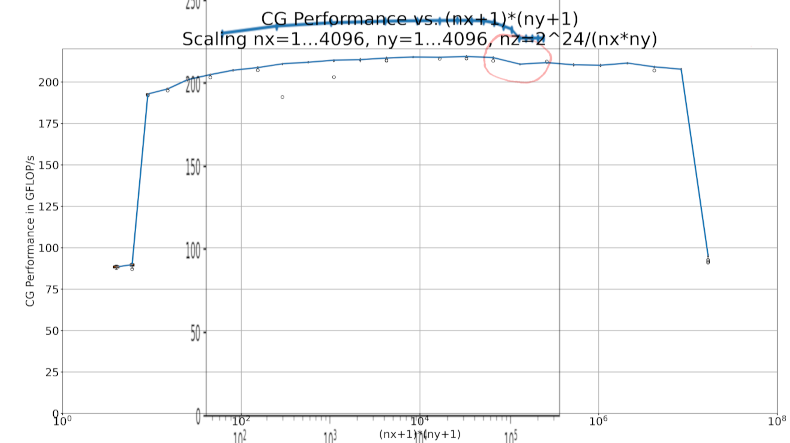

In [ ]:
fig,ax = plt.subplots(figsize=(8,4), dpi=200)


ax.plot([xy*xy for xy in preds[1].keys()],  [(preds[1][key].memLoadV3 + preds[1][key].memStoreV2) / 27 / 2 for key in preds[1].keys()], ".-")
    
ax.set_xscale("log")
#ax.set_ylim((0, ax.get_ylim()[1] * 1.2))

plt.show()

## Discussion
 - Does this only work for the unrealistic case of pseudo-unstructured matrices à la minFE/HPCG, or could proxy access pattern work for other matrices? 
 - Why does it overpredict?
 - What are other interesting things to study?
 
 
 ## Other interesting things to study #1: SpMMV

In [ ]:
xySizes = [8, 16, 32] + [i * 64 for i in range(1, 16)]

for vectorCount in [1, 4, 8, 16, 32]:
    if not vectorCount in preds:
        preds[vectorCount] = predictMiniFESeries(xySizes, DeviceAmpereA100_80GB(), vectorCount)
    


In [ ]:
fig,ax = plt.subplots(figsize=(8,4), dpi=200)

for vectorCount in preds.keys():
    ax.plot([xy*xy for xy in preds[vectorCount].keys()],  [preds[vectorCount][key].perfV3 for key in preds[vectorCount].keys()], ".-", label="NB=" + str(vectorCount))

ax.legend()
ax.set_xscale("log")
ax.set_ylim((0, ax.get_ylim()[1]))

plt.show()

In [ ]:
xySizes = [8, 16, 32] + [i * 64 for i in range(1, 16)]
predsV100 = {}
for vectorCount in [1, 4]:
    if not vectorCount in predsV100:
        predsV100[vectorCount] = predictMiniFESeries(xySizes, DeviceVolta(), vectorCount)

## V100 vs A100

In [ ]:
fig,ax = plt.subplots(figsize=(8,4), dpi=200)

for vectorCount in [1,4]:
    ax.plot([xy*xy for xy in predsV100[vectorCount].keys()],  [predsV100[vectorCount][key].perfV3 for key in predsV100[vectorCount].keys()], "x-", label="V100, NB=" + str(vectorCount), color="C"+str(vectorCount//2))
    ax.plot([xy*xy for xy in preds[vectorCount].keys()],  [preds[vectorCount][key].perfV3 for key in preds[vectorCount].keys()], ".-", label="A100, NB=" + str(vectorCount), color="C" + str(vectorCount-1))

ax.legend()
ax.set_xscale("log")
ax.set_ylim((0, ax.get_ylim()[1]))

plt.show()